# Problem 1:

Note for no layers, we have 784 inputs going to 10 outputs, and we assume a bias term per each.  This will yield 
$10 \cdot 784 $ parameters, as we have each pixel weighted, and 10 outputs, with a further 10 bias terms, one for each 
output node.  Therefore there is a total of $7840 + 10 = 7850$ parameters when we don't include a hidden layer.

If a model has $k$ hidden layers with $m$ nodes a piece we have the following calculation: For the first layer we have $784m + m$ parameters for intaking from the image to the first layer.  For the next $k-1$ layers, for each layer we have $m^2$ 
interconnects, and $m$ bias terms yielding $(k-1)(m^2 + m)$ parameters.  Finally we have $10m$ connections into the output layer, with an additionally $10$ bias.  Therefore, $$Params(m,k) = 784m + m + (k-1)(m^2 + m) + 10(m+1)$$.

# Problem 2:

For a given number of parameters P, we have the equation $784m + m + (k-1)(m^2 + m) + 10(m+1) = P.$  We can rearrange the equation to find that $k = \frac{P-10}{m(m+1)} - \frac{795}{m+1} + 1$.  In order to maximize/minimize the function 
we can take the m derivative, and set the numerator of the fraction equal to zero.  In this scenerio 
we have to solve the equation $0=-795m^2 + 2(P-10)m + (P-10)$.  This has the resulting $m$ values of 
$$ m = \frac{1}{795} \left(P-10 \pm \sqrt{(P-10)^2+795(P-10)} \right) $$.  Note that for sufficently large $P$ that 
the square root will always be positive, thus we will always have two roots, a maximum and a minimum.  However, 
for the smaller of the two roots, the limit approaches -0.5, and since we know that by our model we have to have at least 1 parameter per layer implies that solving for $m=1$ will yield $k_p$.  For the smallest $k$, we know for the smaller root $m_b$ that $\lim_{P \to \infty} k(m_b) = -1$.  Thus 
the smallest possible $k$ would have to be $k=1$.  Note that if $k_p$ is not an integer then one should round $k_p$ down since $m$ is already the 
correct integer value of a solution, ensuring that the actual number of parameters used falls "under budget".  

# Problem 3:

In [4]:
def m_num(k,P):
    if k == 1:
        return (P-10) // 795
    else:
        return (int)(-1*(794+k) + math.sqrt((794+k)**2 + 4*(P-10)*(k-1)))// (2*(k-1))

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import math
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


In [7]:
test_x = torch.Tensor( testset.data ) / 256.0 - 0.5
test_x = test_x.to(device)
test_y = torch.Tensor( testset.targets ).long()
test_y = test_y.to(device)
train_x = torch.Tensor( trainset.data ) / 256.0 - 0.5
train_x = train_x.to(device)
train_y = torch.Tensor( trainset.targets ).long()
train_y = train_y.to(device)

In [8]:
def get_batch(x, y, batch_size):
    n = x.shape[0]

    batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )

    x_batch = x[ batch_indices ]
    y_batch = y[ batch_indices ]

    return x_batch, y_batch

In [12]:
class layerTesting(nn.Module):
    def __init__(self,k,m):
        super(layerTesting, self).__init__()

        self.layer_input = torch.nn.Linear( in_features = 28*28*1, out_features = m, bias=True )
        self.layer_output = torch.nn.Linear( in_features = m, out_features = 10, bias=True )
        self.linears = nn.ModuleList([nn.Linear(m, m) for i in range(k-1)])
        self.normalize = nn.LayerNorm(m)

    def forward(self, input_tensor):
        output = nn.Flatten()( input_tensor )
        output = self.layer_input(output)
        output = nn.ELU()(output)
        output = self.normalize(output)
        for l in self.linears:
            output = l(output)
            output = nn.ELU()(output)
            output = self.normalize(output)
        output = self.layer_output(output)
        return output

In [8]:
class LinearSoftmaxRegression(nn.Module):
    def __init__(self):
        super(LinearSoftmaxRegression, self).__init__()

        self.layer_1 = torch.nn.Linear( in_features = 28*28*1, out_features = 10, bias=True )

    def forward(self, input_tensor):
        flattened = nn.Flatten()( input_tensor )

        logits = self.layer_1( flattened )

        return logits

        # NOTE: Correcting a mistake I made previously, I am outputing the results of a linear layer,
        # For softmax to be applied elsewhere. Shiwei correctly pointed out that if we use the built in
        # cross entropy loss function, it expects to receive these linear values, and will apply
        # logOfSoftmax internally when calculating the loss, so that we don't have to.

        # But if we want the probabilities, we do need to apply softmax

In [13]:
def confusion_matrix( model, x, y ):
    identification_counts = np.zeros( shape = (10,10), dtype = np.int32 )
    
    logits = model.forward( x )
    predicted_classes = torch.argmax( logits, dim = 1 )

    n = x.shape[0]

    for i in range(n):
        actual_class = int( y[i].item() )
        predicted_class = predicted_classes[i].item()
        identification_counts[actual_class, predicted_class] += 1

    return identification_counts

In [20]:
loss_function = torch.nn.CrossEntropyLoss()

In [14]:
import time
model3 = layerTesting(3,m_num(3,100000))
model3.to(device)
loss_function = torch.nn.CrossEntropyLoss()

print("Initial Confusion Matrix")
print( confusion_matrix( model3, test_x, test_y ) )

Initial Confusion Matrix
[[  7  74   0  25   0   0   1  73 780  20]
 [  0   0   0 305   0   0   0  14 816   0]
 [ 18 102   1  25   0   4   1   6 875   0]
 [ 28 117   0 107   0   5   2  27 724   0]
 [156  82  15 256   0   0   0  79 394   0]
 [  8  91   1 123   0   0   4 128 532   5]
 [  1 126   6  56   0   7   0  23 737   2]
 [ 86  92   2 327   0   0   0 119 402   0]
 [  8  49   4  92   0  19   1 155 645   1]
 [ 68  44   2 295   0   0   1 333 266   0]]


Based off of Dr.Cowan's suggestions, I'm using $P=100000$ and $k=1\ldots 10$

In [59]:
P = 100000
batch_size = 256
finalLossTest = []
finalLossTrain = []
trainingTime = []
for k in range(1,10+1):
    model = layerTesting(k,m_num(k,P))
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.001 )
    startTime = time.time()
    for epochs in range(25):
        total_loss = 0
        for batch in range( train_x.shape[0] // batch_size ):
            x_batch, y_batch = get_batch(train_x, train_y, batch_size)
            
            optimizer.zero_grad()
    
            logits = model( x_batch )
            loss = loss_function( logits, y_batch )
    
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
        print( k,"layer(s), total Loss over Batches:",total_loss )
    endTime = time.time()
    trainingTime.append(endTime - startTime)
    finalLossTest.append(loss_function(model(test_x), test_y))
    finalLossTrain.append(loss_function(model(train_x), train_y))
    print("Current Confusion Matrix")
    print( confusion_matrix( model, test_x, test_y ) )
    print()

1 layer(s), total Loss over Batches: 110.49126586318016
1 layer(s), total Loss over Batches: 61.381896272301674
1 layer(s), total Loss over Batches: 44.912227280437946
1 layer(s), total Loss over Batches: 34.75662039220333
1 layer(s), total Loss over Batches: 28.89867513626814
1 layer(s), total Loss over Batches: 24.552714709192514
1 layer(s), total Loss over Batches: 20.525830760598183
1 layer(s), total Loss over Batches: 18.84592240676284
1 layer(s), total Loss over Batches: 16.30835804156959
1 layer(s), total Loss over Batches: 14.613360998220742
1 layer(s), total Loss over Batches: 13.085324857383966
1 layer(s), total Loss over Batches: 11.796505209989846
1 layer(s), total Loss over Batches: 11.293652897700667
1 layer(s), total Loss over Batches: 9.772256398573518
1 layer(s), total Loss over Batches: 10.152841174043715
1 layer(s), total Loss over Batches: 8.770014866255224
1 layer(s), total Loss over Batches: 7.820822774898261
1 layer(s), total Loss over Batches: 7.324606569018215


In [261]:
print(finalLossTest[5].item())

0.07250629365444183


Text(0, 0.5, 'testing loss')

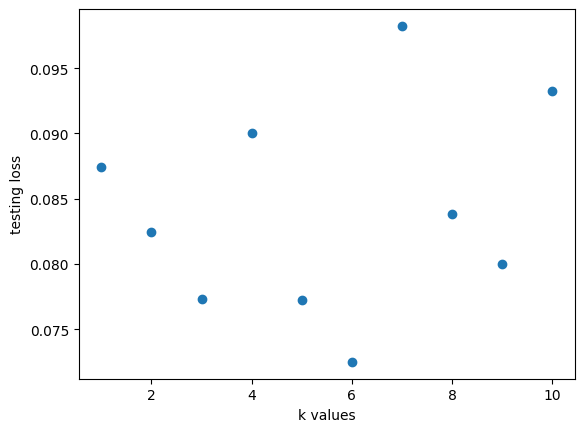

In [260]:
plt.plot([i for i in range(1,11)],[j.item() for j in finalLossTest],'o')
plt.xlabel("k values")
plt.ylabel("testing loss")

Text(0, 0.5, 'training loss')

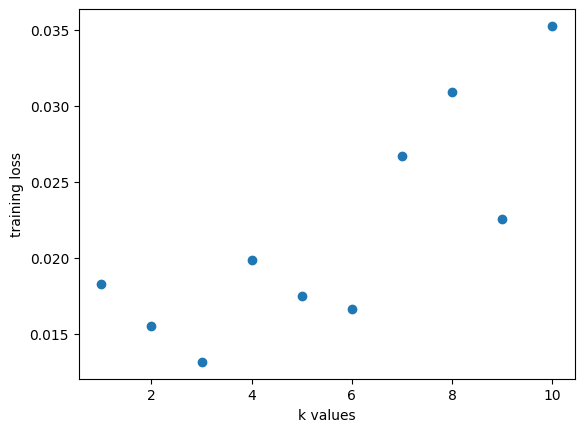

In [106]:
plt.plot([i for i in range(1,11)],[j.item() for j in finalLossTrain],'o')
plt.xlabel("k values")
plt.ylabel("training loss")

Now for comparison with the no hidden layers linear model:

In [38]:
model = LinearSoftmaxRegression()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0005 )

for epochs in range(25):
    total_loss = 0
    for batch in range( train_x.shape[0] // batch_size ):
        x_batch, y_batch = get_batch(train_x, train_y, batch_size)
        
        optimizer.zero_grad()

        logits = model( x_batch )
        loss = loss_function( logits, y_batch )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print("total Loss over Batches:",total_loss )

total Loss over Batches: 266.8634445667267
total Loss over Batches: 133.9680559337139
total Loss over Batches: 108.16572540998459
total Loss over Batches: 96.46211349964142
total Loss over Batches: 87.94975793361664
total Loss over Batches: 84.07725578546524
total Loss over Batches: 80.26980520784855
total Loss over Batches: 79.16002659499645
total Loss over Batches: 77.0686764717102
total Loss over Batches: 73.97362124919891
total Loss over Batches: 73.07093866169453
total Loss over Batches: 71.4469300955534
total Loss over Batches: 70.69508345425129
total Loss over Batches: 70.02656215429306
total Loss over Batches: 69.9735946059227
total Loss over Batches: 68.42793133854866
total Loss over Batches: 69.31025591492653
total Loss over Batches: 67.01877181231976
total Loss over Batches: 67.50968319177628
total Loss over Batches: 68.02158491313457


In [39]:
print("No hidden layers training loss: "+str(loss_function(model(train_x), train_y).item()))
print("No hidden layers testing loss: "+ str(loss_function(model(test_x), test_y).item()))
print("Current Confusion Matrix")
print( confusion_matrix( model, test_x, test_y ) )

No hidden layers training loss: 0.28607186675071716
No hidden layers testing loss: 0.28210288286209106
Current Confusion Matrix
[[ 961    0    3    2    0    5    6    1    2    0]
 [   0 1110    2    2    0    2    4    2   13    0]
 [   9   10  924   13   13    4    9   11   32    7]
 [   3    1   25  903    0   35    2   13   15   13]
 [   1    2    4    1  918    1   10    2    8   35]
 [   9    3    5   29    8  785   12    8   25    8]
 [  12    3    9    1   13   19  897    2    2    0]
 [   2   11   21    8    6    1    0  939    2   38]
 [  10    9    8   20    9   36   10   11  852    9]
 [  11    6    2    9   38    6    0   23    7  907]]


## How do the results compare to the baseline performance of the linear softmax model?

The testing loss of the linear model is double the largest testing loss of the worst hidden layer model.

## What do you notice about the underlying trends? Is there a point where layers become too narrow to be useful, and if so, where is it? What seems to be the sweet spot, if any, for network shape? How does it depend on P?

It seems like performance gets worse with the increase in the number of hidden layers.  
Note that there isn't a clear trend in the testing data.  Some iterations of the model don't have this artifact.  Broadly speaking it seems like the less layers the better.  I can't speak on $P$ dependence because I fixed $P= 100000$ as Dr.Cowan did.

# Training time vs. number of hidden layers

Text(0, 0.5, 'training time (in seconds)')

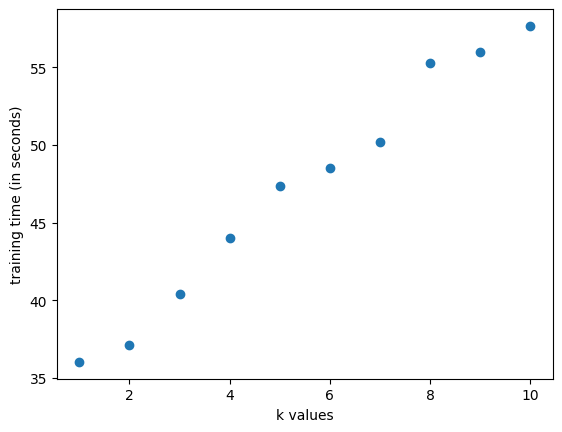

In [63]:
plt.plot([i for i in range(1,11)],[j for j in trainingTime],'o')
plt.xlabel("k values")

plt.ylabel("training time (in seconds)")

The plot above clearly shows for more layers the network takes longer to train on the same number of epochs.  This further enforces my belief that thinner networks are better networks.

# Problem 4:

In [14]:
def totalParams(model):
    totalParam = 0
    for parameter in model.parameters():
        totalParam = totalParam + parameter.numel()
    return totalParam

In [15]:
def trainNetwork(model, device, train_x, train_y, text_x, test_y, loss_function, optimFunc, batch_size, learnRate):
    model = model.to(device)
    optimizer = optimFunc(model.parameters(), lr = learnRate )
    testLoss = loss_function(model(test_x),test_y).item()
    startTime = time.time()
    for epochs in range(30):
        total_loss = 0
        for batch in range( train_x.shape[0] // batch_size ):
            x_batch, y_batch = get_batch(train_x, train_y, batch_size)
            
            optimizer.zero_grad()
    
            logits = model( x_batch )
            loss = loss_function( logits, y_batch )
    
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
        print("epochs: " + str(1+epochs) + " total Loss over Batches: " + str(total_loss) + " test loss: " + str(testLoss) )
        # if loss_function(model(test_x),test_y).item() > testLoss*1.1:
        #     break
        # else:
        testLoss = loss_function(model(test_x),test_y).item()
    endTime = time.time()
    return endTime-startTime, loss_function(model(train_x),train_y).item(), testLoss

        

125
110
100
92
87
82
78
75
72
69


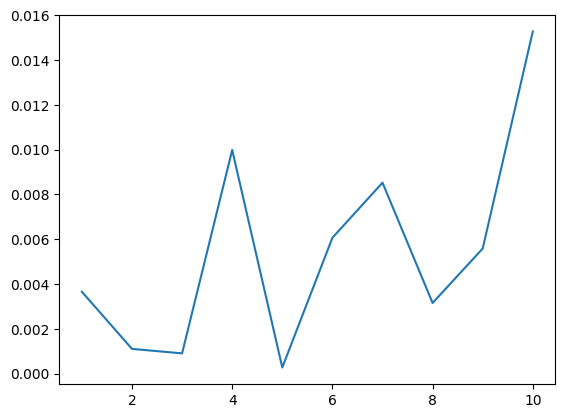

In [240]:
plt.plot([i for i in range(1,11)],[ abs(P-totalParams(layerTesting(i,m_num(i,P))))/P for i in range(1,11)])
for i in range(1,11):
    print(m_num(i,P))

In [13]:
model = layerTesting(3,m_num(3,P))

print(totalParams(model))

NameError: name 'layerTesting' is not defined

In [9]:
class badVGGDec(nn.Module):
    def __init__(self):
        super(badVGGDec, self).__init__()

        self.layer_input = nn.Sequential(nn.Linear( in_features = 28*28*1, out_features = 95, bias=True ), nn.LayerNorm(95), nn.ELU())
        self.layer_output = torch.nn.Linear( in_features = 82, out_features = 10, bias=True )
        self.linears = nn.ModuleList([nn.Sequential(nn.Linear(95, 90), nn.LayerNorm(90), nn.ELU()),
                                      nn.Sequential(nn.Linear(90, 87), nn.LayerNorm(87), nn.ELU()),
                                      nn.Sequential(nn.Linear(87, 82), nn.LayerNorm(82), nn.ELU())])
    def forward(self, input_tensor):
        output = nn.Flatten()( input_tensor )
        output = self.layer_input(output)
        for l in self.linears:
                output = l(output)
        output = self.layer_output(output)
        return output

In [278]:
class badVGGAsc(nn.Module):
    def __init__(self):
        super(badVGGAsc, self).__init__()

        self.layer_input = nn.Sequential(nn.Linear( in_features = 28*28*1, out_features = 87, bias=True ), nn.LayerNorm(87), nn.ELU())
        self.layer_output = torch.nn.Linear( in_features = 110, out_features = 10, bias=True )
        self.linears = nn.ModuleList([nn.Sequential(nn.Linear(100, 110), nn.LayerNorm(110), nn.ELU()),
                                      nn.Sequential(nn.Linear(90, 100), nn.LayerNorm(100), nn.ELU()),
                                      nn.Sequential(nn.Linear(87, 90), nn.LayerNorm(90), nn.ELU())])
    def forward(self, input_tensor):
        output = nn.Flatten()( input_tensor )
        output = self.layer_input(output)
        for l in reversed(self.linears):
                output = l(output)
        output = self.layer_output(output)
        return output

In [318]:
model1 = badVGGDec()
print(totalParams(model1))

99886


In [319]:
trainNetwork(model1, device, train_x, train_y, test_x, test_y, loss_function, optim.Adam, 256, 0.0004)
# model = model.to(device)
# optimizer = optim.Adam(model.parameters(), lr = 0.001 )

# for epochs in range(40):
#     total_loss = 0
#     for batch in range( train_x.shape[0] // batch_size ):
#         x_batch, y_batch = get_batch(train_x, train_y, batch_size)
        
#         optimizer.zero_grad()

#         logits = model( x_batch )
#         loss = loss_function( logits, y_batch )

#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     print("layer(s), total Loss over Batches:",total_loss )

epochs: 1 total Loss over Batches: 119.24925297498703 test loss: 2.3797810077667236
epochs: 2 total Loss over Batches: 46.238544560968876 test loss: 0.2345850169658661
epochs: 3 total Loss over Batches: 32.78550262004137 test loss: 0.15872162580490112
epochs: 4 total Loss over Batches: 26.247574012726545 test loss: 0.12258315086364746
epochs: 5 total Loss over Batches: 21.73243731074035 test loss: 0.10560594499111176
epochs: 6 total Loss over Batches: 19.50059736147523 test loss: 0.09950949996709824
epochs: 7 total Loss over Batches: 17.423807747662067 test loss: 0.09810847043991089
epochs: 8 total Loss over Batches: 14.755033422261477 test loss: 0.08864877372980118
epochs: 9 total Loss over Batches: 13.728905508294702 test loss: 0.0854114219546318
epochs: 10 total Loss over Batches: 13.275696613825858 test loss: 0.09054294973611832
epochs: 11 total Loss over Batches: 11.563978120684624 test loss: 0.081595778465271
epochs: 12 total Loss over Batches: 11.651830056682229 test loss: 0.079

(48.99853253364563, 0.017525294795632362, 0.06678382307291031)

In [299]:
print(loss_function(model1(test_x),test_y).item())
print(loss_function(model1(train_x),train_y).item())

0.08195707947015762
0.02052256464958191


In [320]:
model2 = badVGGAsc()
print(totalParams(model2))

98309


In [321]:
trainNetwork(model2, device, train_x, train_y, test_x, test_y, loss_function, optim.Adam, 256,0.0004)

epochs: 1 total Loss over Batches: 114.36639992892742 test loss: 2.4027390480041504
epochs: 2 total Loss over Batches: 43.22977264225483 test loss: 0.22474659979343414
epochs: 3 total Loss over Batches: 31.085518423467875 test loss: 0.1658814400434494
epochs: 4 total Loss over Batches: 25.80313180014491 test loss: 0.13634245097637177
epochs: 5 total Loss over Batches: 21.19843821041286 test loss: 0.12373845279216766
epochs: 6 total Loss over Batches: 20.03904812783003 test loss: 0.09590223431587219
epochs: 7 total Loss over Batches: 16.440734358504415 test loss: 0.09162697196006775
epochs: 8 total Loss over Batches: 14.452215984463692 test loss: 0.08741438388824463
epochs: 9 total Loss over Batches: 13.104112600907683 test loss: 0.0922897607088089
epochs: 10 total Loss over Batches: 12.707748303189874 test loss: 0.08670751005411148
epochs: 11 total Loss over Batches: 11.568751531653106 test loss: 0.115187868475914
epochs: 12 total Loss over Batches: 11.365066163241863 test loss: 0.0892

(48.015636920928955, 0.023185379803180695, 0.08347839117050171)

In [295]:
print(loss_function(model2(test_x),test_y).item())
print(loss_function(model2(train_x),train_y).item())

0.08538950234651566
0.017661165446043015


Above are the two different architectures I tried after a lot of experimentation.  Broadly speaking I have 3 different types of architectures, 
the architecture with the same sized hidden layers, decreasing, and increasing.  For the decreasing and increasing ones, I used the numbers computed above of the "ideal" $m$ for each $k$ to maintain approximately $P = 100000$, and made my layers decrease within those bounds, roughly.  Ultimately 
I was able to slightly beat my best uniform layer model by my decreasing model, but not by much.  I also only got to this performance by greatly restricting the number of layers for both the decreasing and increasing.  Generally the increasing did worse than the increasing, however their 
performances were always on average to better than average for the uniform layer models tested.  

## Problem 5:

In [23]:
telemVect = [(13036.46961259842, 0.03382675722241402, 0.12305501848459244)]
flag = 1
for i in range(1,11): 
    model1 = badVGGDec()
    telemVect.append(trainNetwork(model1, device, train_x, train_y, test_x, test_y, loss_function, optim.Adam, 2**i, 0.0004))
        

epochs: 1 total Loss over Batches: 9858.104459446971 test loss: 2.3075947761535645
epochs: 2 total Loss over Batches: 5191.653352875321 test loss: 0.1725383847951889
epochs: 3 total Loss over Batches: 3993.7492698884307 test loss: 0.21757301688194275
epochs: 4 total Loss over Batches: 3313.0694510769463 test loss: 0.13155031204223633
epochs: 5 total Loss over Batches: 2922.7617578137324 test loss: 0.11201583594083786
epochs: 6 total Loss over Batches: 2478.5719642472723 test loss: 0.09563594311475754
epochs: 7 total Loss over Batches: 2249.45192943444 test loss: 0.09406843781471252
epochs: 8 total Loss over Batches: 2062.8408026408015 test loss: 0.09922480583190918
epochs: 9 total Loss over Batches: 1977.8993834793955 test loss: 0.1123293787240982
epochs: 10 total Loss over Batches: 1699.4983574341913 test loss: 0.0928146168589592
epochs: 11 total Loss over Batches: 1654.8017164332373 test loss: 0.08624410629272461
epochs: 12 total Loss over Batches: 1478.6129457951845 test loss: 0.081

In [25]:
print(telemVect)

[(13036.46961259842, 0.03382675722241402, 0.12305501848459244), (6562.883058547974, 0.015300864353775978, 0.0934378057718277), (3183.235205888748, 0.01433180458843708, 0.08101391047239304), (1710.4872753620148, 0.015110546723008156, 0.08527244627475739), (822.2498369216919, 0.014046361669898033, 0.07801202684640884), (400.8892045021057, 0.0167524516582489, 0.07824046909809113), (194.1204981803894, 0.014452595263719559, 0.07093526422977448), (101.83412170410156, 0.018164929002523422, 0.08297684788703918), (49.731972217559814, 0.015558088198304176, 0.07996919751167297), (25.997329235076904, 0.017127996310591698, 0.08602001518011093), (14.694605827331543, 0.020560668781399727, 0.07646508514881134)]


Text(0, 0.5, 'training time (in seconds)')

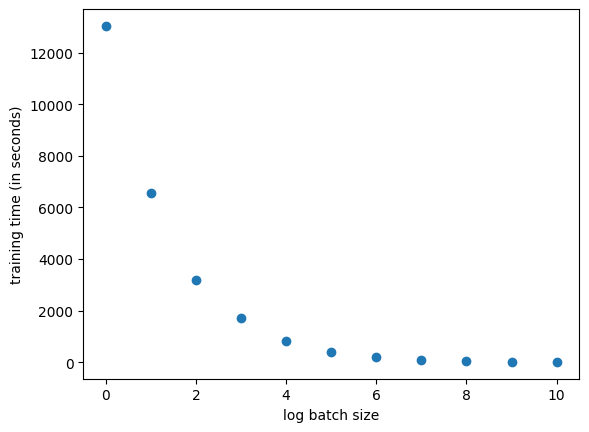

In [26]:
plt.plot([i for i in range(11)],[telemVect[j][0] for j in range(11)],'o')
plt.xlabel("log batch size")

plt.ylabel("training time (in seconds)")

Text(0, 0.5, 'training loss')

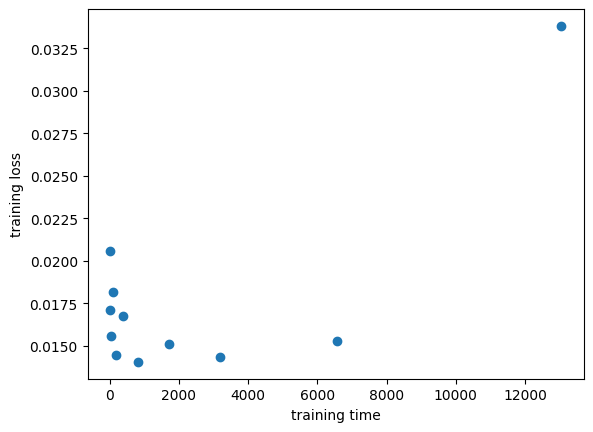

In [27]:
plt.plot([telemVect[j][0] for j in range(11)],[telemVect[j][1] for j in range(11)],'o')
plt.xlabel("training time")

plt.ylabel("training loss")

Text(0, 0.5, 'testing loss')

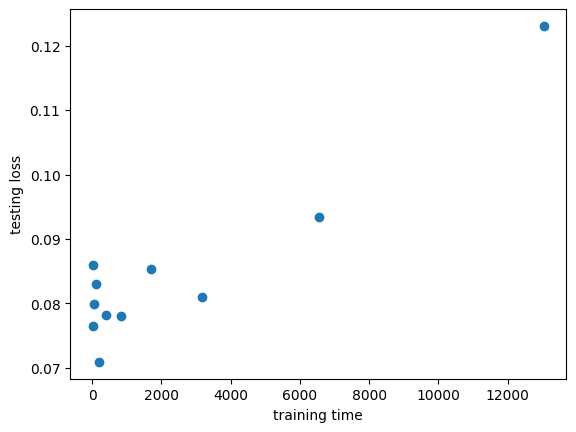

In [28]:
plt.plot([telemVect[j][0] for j in range(11)],[telemVect[j][2] for j in range(11)],'o')
plt.xlabel("training time")

plt.ylabel("testing loss")

My observations are thus:  Since I'm using a log scale for the batch size relative to training time, it seems like there's a linear negative correlation between batch size and training time.  Furthermore, it seems like overfitting occurs when the batch size gets too small.  Additionally, it appears that if the batch size gets too large, the network doesn't learn enough specific things about the data to improve elsewhere.  Thus the best batch size is probably between 2^6 and 2^8.  This optimizes for both speed and efficency.  

## Problem 6:

In [29]:
telemVectSGD = []
for i in range(11):
    model1 = badVGGDec()
    telemVectSGD.append(trainNetwork(model1, device, train_x, train_y, test_x, test_y, loss_function, optim.SGD, 2**i, 0.0004))

epochs: 1 total Loss over Batches: 19674.188051770907 test loss: 2.3323094844818115
epochs: 2 total Loss over Batches: 9769.894982326456 test loss: 0.23303112387657166
epochs: 3 total Loss over Batches: 7322.6633551674895 test loss: 0.13251158595085144
epochs: 4 total Loss over Batches: 6111.28082874867 test loss: 0.14073285460472107
epochs: 5 total Loss over Batches: 5143.507371292464 test loss: 0.09907019138336182
epochs: 6 total Loss over Batches: 4600.467052147629 test loss: 0.11605986207723618
epochs: 7 total Loss over Batches: 3956.889210523859 test loss: 0.10460826754570007
epochs: 8 total Loss over Batches: 3837.5782685207814 test loss: 0.08689320087432861
epochs: 9 total Loss over Batches: 3328.1667974837983 test loss: 0.08707910776138306
epochs: 10 total Loss over Batches: 2940.7260133225936 test loss: 0.08400827646255493
epochs: 11 total Loss over Batches: 2881.5617892953287 test loss: 0.077846460044384
epochs: 12 total Loss over Batches: 2602.982517512929 test loss: 0.08324

In [31]:
print(telemVectSGD)

[(10669.09851861, 0.01231697853654623, 0.07802053540945053), (5195.681214332581, 0.012474171817302704, 0.06832105666399002), (2592.011132478714, 0.01834491640329361, 0.07189051806926727), (1297.135125875473, 0.030794860795140266, 0.08540330082178116), (651.5786099433899, 0.04848138242959976, 0.08271181583404541), (333.7358591556549, 0.09200742095708847, 0.11504270136356354), (168.5026559829712, 0.1513073742389679, 0.1599246710538864), (86.01596021652222, 0.24530895054340363, 0.24727502465248108), (44.56360125541687, 0.3531096577644348, 0.3465297520160675), (23.822059869766235, 0.49646496772766113, 0.48391279578208923), (12.524090766906738, 0.7650962471961975, 0.7495924234390259)]


Text(0, 0.5, 'training time (SGD) (in seconds)')

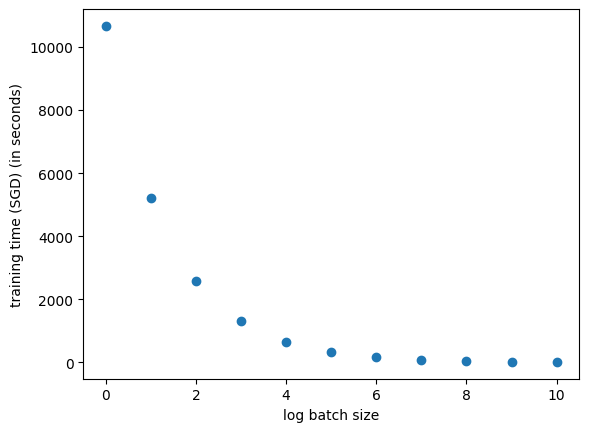

In [34]:
plt.plot([i for i in range(11)],[telemVectSGD[j][0] for j in range(11)],'o')
plt.xlabel("log batch size")

plt.ylabel("training time (SGD) (in seconds)")

Text(0, 0.5, 'training loss')

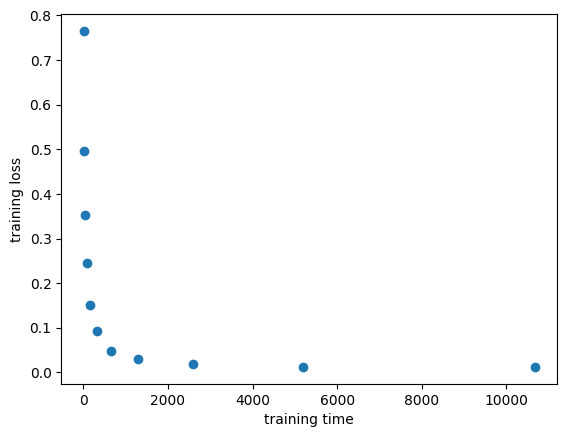

In [35]:
plt.plot([telemVectSGD[j][0] for j in range(11)],[telemVectSGD[j][1] for j in range(11)],'o')
plt.xlabel("training time")

plt.ylabel("training loss")

Text(0, 0.5, 'testing loss')

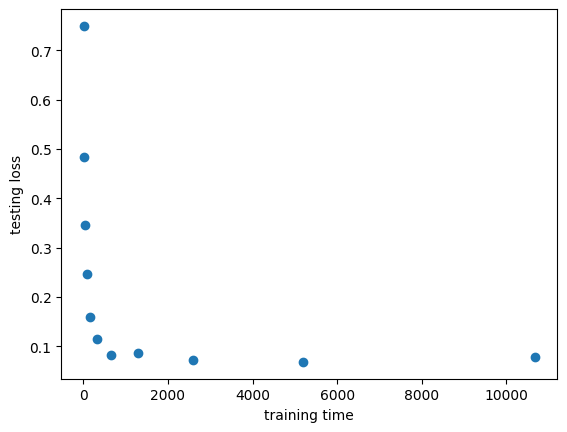

In [57]:
plt.plot([telemVectSGD[j][0] for j in range(11)],[telemVectSGD[j][2] for j in range(11)],'o')
plt.xlabel("training time")

plt.ylabel("testing loss")

My observations, it seems like SGD behaves much more concistently then adam.  Given that SGD doesn't have a convoluted formula for changing momentum it makes sense.  Additionally the smaller the step size the better for SGD.  Somehow SGD doesn't suffer from the overfitting issue that Adam has for training on single items.  For SGD to determine the ideal step size is entirely determined on how much time you have.  Note that I ran all of these batch size calculations either over night or leveraging many GPUs on the ilabs.  I elect to still use 2^8 with adam for the most "efficent" learning for my time, however if I truly cared about getting the best number recognizer I could possibly make I would train with SGD for many days.  

## Problem 7:

In [61]:
class badVGGDecACTIVE(nn.Module):
    def __init__(self, activate):
        super(badVGGDecACTIVE, self).__init__()

        self.layer_input = nn.Sequential(nn.Linear( in_features = 28*28*1, out_features = 95, bias=True ), nn.LayerNorm(95), activate)
        self.layer_output = torch.nn.Linear( in_features = 82, out_features = 10, bias=True )
        self.linears = nn.ModuleList([nn.Sequential(nn.Linear(95, 90), nn.LayerNorm(90), activate),
                                      nn.Sequential(nn.Linear(90, 87), nn.LayerNorm(87), activate),
                                      nn.Sequential(nn.Linear(87, 82), nn.LayerNorm(82), activate)])
    def forward(self, input_tensor):
        output = nn.Flatten()( input_tensor )
        output = self.layer_input(output)
        for l in self.linears:
                output = l(output)
        output = self.layer_output(output)
        return output

In [53]:
telemVectReLU = [(8026.298926591873, 0.019757753238081932, 0.10639552026987076), (4497.639342308044, 0.019462598487734795, 0.10854930430650711), (2249.2546079158783, 0.02393030934035778, 0.10531783103942871), (1142.5151562690735, 0.00730768870562315, 0.08223047107458115), (566.090441942215, 0.00804184377193451, 0.07888971269130707), (278.66801357269287, 0.013714738190174103, 0.07731867581605911), (141.97045946121216, 0.00875855889171362, 0.06882525980472565), (72.23443937301636, 0.015324380248785019, 0.08400358259677887), (35.861645460128784, 0.03460041433572769, 0.12367768585681915), (18.961389303207397, 0.011796741746366024, 0.08745428919792175), (9.988064765930176, 0.01684384234249592, 0.09590775519609451)]
telemVectSigmoid = [(8617.39876627922, 0.017453668639063835, 0.09983742982149124), (4397.586535215378, 0.029443111270666122, 0.10772351175546646), (2194.0753045082092, 0.02739831805229187, 0.10344068706035614), (1108.89591050148, 0.0471423864364624, 0.1200360357761383), (557.256781578064, 0.024635693058371544, 0.07794219255447388), (280.6803390979767, 0.03384512662887573, 0.08747555315494537), (140.40541553497314, 0.04522201046347618, 0.09286323189735413), (70.1185896396637, 0.029827576130628586, 0.07586238533258438), (35.211559534072876, 0.0460859052836895, 0.09438417106866837), (18.611412525177002, 0.07242858409881592, 0.11869624257087708), (9.910942316055298, 0.08018287271261215, 0.10775049030780792)]
telemVect = [(13036.46961259842, 0.03382675722241402, 0.12305501848459244), (6562.883058547974, 0.015300864353775978, 0.0934378057718277), (3183.235205888748, 0.01433180458843708, 0.08101391047239304), (1710.4872753620148, 0.015110546723008156, 0.08527244627475739), (822.2498369216919, 0.014046361669898033, 0.07801202684640884), (400.8892045021057, 0.0167524516582489, 0.07824046909809113), (194.1204981803894, 0.014452595263719559, 0.07093526422977448), (101.83412170410156, 0.018164929002523422, 0.08297684788703918), (49.731972217559814, 0.015558088198304176, 0.07996919751167297), (25.997329235076904, 0.017127996310591698, 0.08602001518011093), (14.694605827331543, 0.020560668781399727, 0.07646508514881134)]
telemVectTanh = [(8502.971615314484, 0.015585185959935188, 0.104060597717762), (4334.402366161346, 0.011703713797032833, 0.09588449448347092), (2169.941883325577, 0.01722235046327114, 0.09936504065990448), (1092.6315302848816, 0.019374998286366463, 0.10197627544403076), (551.0835609436035, 0.007633047178387642, 0.07301926612854004), (276.7735815048218, 0.011969544924795628, 0.07937242835760117), (137.548321723938, 0.01700296252965927, 0.08467067778110504), (69.30522513389587, 0.009059500880539417, 0.07907551527023315), (35.16921353340149, 0.012268596328794956, 0.0857546329498291), (18.30043888092041, 0.015024959109723568, 0.08590357005596161), (9.85260272026062, 0.01894312910735607, 0.08335357159376144)]



In [62]:
for i in range(11):
    modelReLU = badVGGDecACTIVE(nn.ReLU())
    telemVectReLU.append(trainNetwork(modelReLU, device, train_x, train_y, test_x, test_y, loss_function, optim.Adam, 2**i, 0.0004))

epochs: 1 total Loss over Batches: 20538.80320756056 test loss: 2.3814198970794678
epochs: 2 total Loss over Batches: 10179.677428767234 test loss: 0.28192389011383057
epochs: 3 total Loss over Batches: 7596.185416956317 test loss: 0.13944171369075775
epochs: 4 total Loss over Batches: 6146.294959731183 test loss: 0.1288885474205017
epochs: 5 total Loss over Batches: 5395.964410381987 test loss: 0.10484366118907928
epochs: 6 total Loss over Batches: 4745.706807964346 test loss: 0.11398264020681381
epochs: 7 total Loss over Batches: 4328.141230181906 test loss: 0.11863622814416885
epochs: 8 total Loss over Batches: 3751.778534049038 test loss: 0.09741624444723129
epochs: 9 total Loss over Batches: 3491.6925528255974 test loss: 0.1034827008843422


MemoryError: 

In [ ]:
for i in range(11):
    modelReLU = badVGGDecACTIVE(nn.Sigmoid())
    telemVectReLU.append(trainNetwork(modelSigmoid, device, train_x, train_y, test_x, test_y, loss_function, optim.Adam, 2**i, 0.0004))

In [ ]:
for i in range(11):
    modelReLU = badVGGDecACTIVE(nn.Tanh())
    telemVectReLU.append(trainNetwork(modelTanh, device, train_x, train_y, test_x, test_y, loss_function, optim.Adam, 2**i, 0.0004))

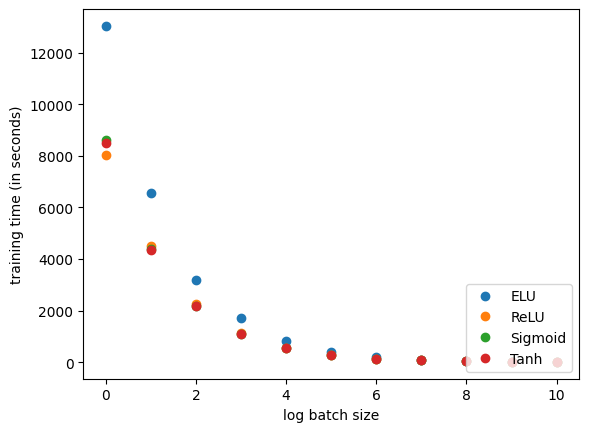

In [58]:
plt.plot([i for i in range(11)],[telemVect[j][0] for j in range(11)],'o')
plt.plot([i for i in range(11)],[telemVectReLU[j][0] for j in range(11)],'o')
plt.plot([i for i in range(11)],[telemVectSigmoid[j][0] for j in range(11)],'o')
plt.plot([i for i in range(11)],[telemVectTanh[j][0] for j in range(11)],'o')
plt.xlabel("log batch size")

plt.ylabel("training time (in seconds)")
plt.legend(["ELU", "ReLU", "Sigmoid", "Tanh"], loc="lower right")

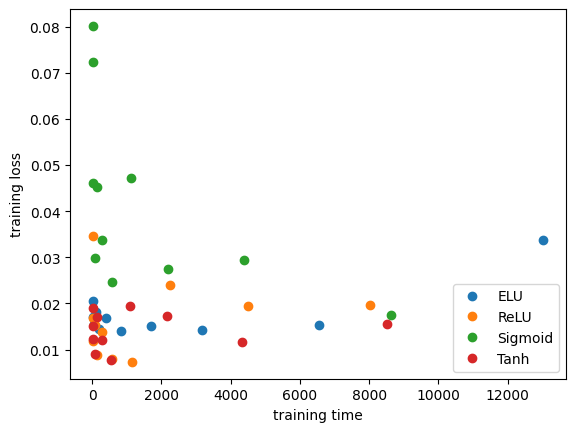

In [59]:
plt.plot([telemVect[j][0] for j in range(11)],[telemVect[j][1] for j in range(11)],'o')
plt.plot([telemVectReLU[j][0] for j in range(11)],[telemVectReLU[j][1] for j in range(11)],'o')
plt.plot([telemVectSigmoid[j][0] for j in range(11)],[telemVectSigmoid[j][1] for j in range(11)],'o')
plt.plot([telemVectTanh[j][0] for j in range(11)],[telemVectTanh[j][1] for j in range(11)],'o')

plt.xlabel("training time")

plt.ylabel("training loss")
plt.legend(["ELU", "ReLU", "Sigmoid", "Tanh"], loc="lower right")

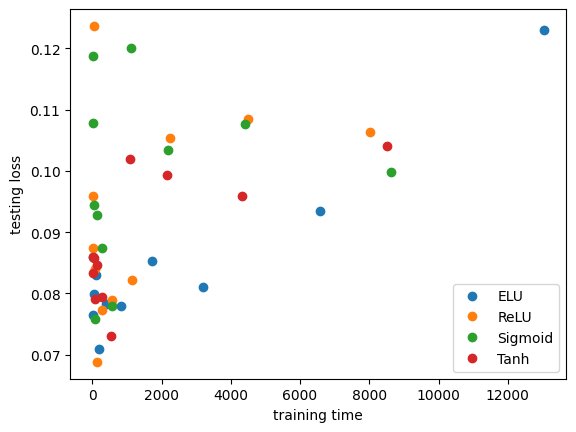

In [60]:
plt.plot([telemVect[j][0] for j in range(11)],[telemVect[j][2] for j in range(11)],'o')
plt.plot([telemVectReLU[j][0] for j in range(11)],[telemVectReLU[j][2] for j in range(11)],'o')
plt.plot([telemVectSigmoid[j][0] for j in range(11)],[telemVectSigmoid[j][2] for j in range(11)],'o')
plt.plot([telemVectTanh[j][0] for j in range(11)],[telemVectTanh[j][2] for j in range(11)],'o')

plt.xlabel("training time")

plt.ylabel("testing loss")
plt.legend(["ELU", "ReLU", "Sigmoid", "Tanh"], loc="lower right")

Note for the program above the data was obtained by running on the ilabs, and is included in the files "activation function"Log.  Broadly it seems that sigmoid performed the worst, ReLU/Tanh the best, and ELU is the in between.  It seems like all activation functions hit the "sweet spot" between 2^6 and 2^8.  It appears that ELU led the pack in terms of training time.  All computation was also done by differentActivation.py.

## Problem 8:

In [17]:
class layerTestingCNN(nn.Module):
    def __init__(self,k,m):
        super(layerTestingCNN, self).__init__()
        self.cnn = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 3, stride = 1, padding = "valid", bias = True)
        self.layer_input = torch.nn.Linear( in_features = 28*28*1, out_features = m, bias=True )
        self.layer_output = torch.nn.Linear( in_features = m, out_features = 10, bias=True )
        self.linears = nn.ModuleList([nn.Linear(m, m) for i in range(k-1)])
        self.normalize = nn.LayerNorm(m)

    def forward(self, input_tensor):
        output = torch.reshape( input_tensor, (-1, 1, 28, 28) )
        output = self.cnn(output)
        output = nn.ELU()(output)
        output = nn.Flatten()( input_tensor )
        output = self.layer_input(output)
        output = nn.ELU()(output)
        output = self.normalize(output)
        for l in self.linears:
            output = l(output)
            output = nn.ELU()(output)
            output = self.normalize(output)
        output = self.layer_output(output)
        return output

In [18]:
telemVectCNN = []

In [21]:
for i in range(1,11):
    model = layerTestingCNN(2,m_num(2,i*10000))
    print("approximately: " + str(i*10000) + " actually: " + str(totalParams(model)))
    telemVectCNN.append(trainNetwork(model, device, train_x, train_y, test_x, test_y, loss_function, optim.Adam, 256, 0.0004))

approximately: 10000 actually: 9740
epochs: 1 total Loss over Batches: 307.9511922597885 test loss: 2.4238266944885254
epochs: 2 total Loss over Batches: 181.03634768724442 test loss: 0.9453418254852295
epochs: 3 total Loss over Batches: 123.40541344881058 test loss: 0.6066827774047852
epochs: 4 total Loss over Batches: 95.76201555132866 test loss: 0.4496120512485504
epochs: 5 total Loss over Batches: 82.28152817487717 test loss: 0.38010352849960327
epochs: 6 total Loss over Batches: 73.23856973648071 test loss: 0.3242194950580597
epochs: 7 total Loss over Batches: 68.08414196968079 test loss: 0.30155619978904724
epochs: 8 total Loss over Batches: 64.08745923638344 test loss: 0.28889912366867065
epochs: 9 total Loss over Batches: 60.71489644050598 test loss: 0.2675187885761261
epochs: 10 total Loss over Batches: 56.48250763118267 test loss: 0.260883629322052
epochs: 11 total Loss over Batches: 55.110482923686504 test loss: 0.24490772187709808
epochs: 12 total Loss over Batches: 52.3384

It appears that at $P=80000$ the network starts to outcompete the best performing architecture I found for one convolution.  I was unable to graph the results due to time constraints

## Problem 9:

In [22]:
class layerTestingCNN2x(nn.Module):
    def __init__(self,k,m):
        super(layerTestingCNN2x, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 3, stride = 1, padding = "valid", bias = True)
        self.cnn2 = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 3, stride = 1, padding = "valid", bias = True)

        self.layer_input = torch.nn.Linear( in_features = 28*28*1, out_features = m, bias=True )
        self.layer_output = torch.nn.Linear( in_features = m, out_features = 10, bias=True )
        self.linears = nn.ModuleList([nn.Linear(m, m) for i in range(k-1)])
        self.normalize = nn.LayerNorm(m)

    def forward(self, input_tensor):
        output = torch.reshape( input_tensor, (-1, 1, 28, 28) )
        output = self.cnn1(output)
        output = nn.ELU()(output)
        output = self.cnn2(output)
        output = nn.ELU()(output)
        output = nn.Flatten()( input_tensor )
        output = self.layer_input(output)
        output = nn.ELU()(output)
        output = self.normalize(output)
        for l in self.linears:
            output = l(output)
            output = nn.ELU()(output)
            output = self.normalize(output)
        output = self.layer_output(output)
        return output

In [ ]:
telemVectCNN2x = []
for i in range(1,11):
    model = layerTestingCNN2x(2,m_num(2,i*10000))
    print("approximately: " + str(i*10000) + " actually: " + str(totalParams(model)))
    telemVectCNN2x.append(trainNetwork(model, device, train_x, train_y, test_x, test_y, loss_function, optim.Adam, 256, 0.0004))

approximately: 10000 actually: 9750
epochs: 1 total Loss over Batches: 322.2982341647148 test loss: 2.5482563972473145
epochs: 2 total Loss over Batches: 181.50547415018082 test loss: 0.9471145272254944
epochs: 3 total Loss over Batches: 125.68022185564041 test loss: 0.6155056357383728
epochs: 4 total Loss over Batches: 100.05776345729828 test loss: 0.45811861753463745
epochs: 5 total Loss over Batches: 85.72231116890907 test loss: 0.3915274143218994
epochs: 6 total Loss over Batches: 77.74317206442356 test loss: 0.33733418583869934
epochs: 7 total Loss over Batches: 72.58356693387032 test loss: 0.3113686144351959
epochs: 8 total Loss over Batches: 67.06217432022095 test loss: 0.29545509815216064
epochs: 9 total Loss over Batches: 64.99508726596832 test loss: 0.28086522221565247
epochs: 10 total Loss over Batches: 63.40220719575882 test loss: 0.27539733052253723
epochs: 11 total Loss over Batches: 59.23774856328964 test loss: 0.2788879871368408
epochs: 12 total Loss over Batches: 57.72

  For 2 convolutions it appears that $70000$ now does the trick.  I can beat one convolution

## Problem 10:

In [11]:
def k_num(m,P):
    return 1+((P-10 - 795*m)//(m*(m+1)))

In [40]:
class autoEncoder(nn.Module):
    def __init__(self,k,m):
        super(autoEncoder, self).__init__()
        self.layer_inputF = torch.nn.Linear( in_features = 28*28*1, out_features = m, bias=True )
        self.linearsF = nn.ModuleList([nn.Linear(m, m) for i in range(k-1)])
        self.linearsG = nn.ModuleList([nn.Linear(m, m) for i in range(k-1)])
        self.layer_outputG = torch.nn.Linear(m,784, bias=True)
        self.normalize = nn.LayerNorm(m)
    def First(self, input_tensor):
        output = nn.Flatten()( input_tensor )
        output = self.layer_inputF(output)
        output = nn.ELU()(output)
        output = self.normalize(output)
        for l in self.linearsF:
            output = l(output)
            output = nn.ELU()(output)
            output = self.normalize(output)
        return output
    def G(self, compView):
        output = compView
        for l in self.linearsG:
            output = l(output)
            output = nn.ELU()(output)
            output = self.normalize(output)
        output = self.layer_outputG(output)
        return output
    def forward(self, input_tensor):
        comp = self.First(input_tensor)
        return self.G(comp)

In [13]:
class Fcomp(nn.Module):
    def __init__(self,k,m):
        super(Fcomp, self).__init__()

        self.layer_input = torch.nn.Linear( in_features = 28*28*1, out_features = m, bias=True )
        self.linears = nn.ModuleList([nn.Linear(m, m) for i in range(k-1)])
        self.normalize = nn.LayerNorm(m)

    def forward(self, input_tensor):
        output = nn.Flatten()( input_tensor )
        output = self.layer_input(output)
        output = nn.ELU()(output)
        output = self.normalize(output)
        for l in self.linears:
            output = l(output)
            output = nn.ELU()(output)
            output = self.normalize(output)
        return output

In [19]:
modelF = Fcomp(k_num(2,50000),2)
print(totalParams(modelF))

49970


In [21]:
class Gexp(nn.Module):
    def __init__(self,k,m):
        super(Gexp, self).__init__()

        self.linears = nn.ModuleList([nn.Linear(m, m) for i in range(k-1)])
        self.layer_output = torch.nn.Linear(m,784, bias=True)
        self.normalize = nn.LayerNorm(m)

    def forward(self, input_tensor):
        output = input_tensor
        for l in self.linears:
            output = l(output)
            output = nn.ELU()(output)
            output = self.normalize(output)
        output = self.layer_output(output)
        return output

In [30]:
modelG = Gexp(k_num(7,50000),7)
print(totalParams(modelG))

50694


In [ ]:
modelCollect = []

In [50]:
P = 50000
batch_size = 512
finalLossTest = []
finalLossTrain = []
trainingTime = []
loss_function = nn.MSELoss()
for k in range(10,20+1):
    model = autoEncoder(k_num(k,P),k)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.0001 )
    startTime = time.time()
    for epochs in range(25):
        total_loss = 0
        for batch in range( train_x.shape[0] // batch_size ):
            x_batch, y_batch = get_batch(train_x, train_y, batch_size)
            
            optimizer.zero_grad()
    
            loss = loss_function( model(x_batch), nn.Flatten()(x_batch) )
    
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
        print( k,"input node(s), total Loss over Batches:",total_loss )
    endTime = time.time()
    trainingTime.append(endTime - startTime)
    finalLossTest.append(loss_function( model(test_x), nn.Flatten()(test_x) ))
    finalLossTrain.append(loss_function( model(train_x), nn.Flatten()(train_x) ))
    modelCollect.append(model)

10 input node(s), total Loss over Batches: 57.60735630989075
10 input node(s), total Loss over Batches: 44.175395876169205
10 input node(s), total Loss over Batches: 33.54171034693718
10 input node(s), total Loss over Batches: 26.1003220975399
10 input node(s), total Loss over Batches: 20.981592923402786
10 input node(s), total Loss over Batches: 17.39261056482792
10 input node(s), total Loss over Batches: 14.808156706392765
10 input node(s), total Loss over Batches: 12.928122274577618
10 input node(s), total Loss over Batches: 11.525915838778019
10 input node(s), total Loss over Batches: 10.52466605603695
10 input node(s), total Loss over Batches: 9.764614395797253
10 input node(s), total Loss over Batches: 9.197238311171532
10 input node(s), total Loss over Batches: 8.779435284435749
10 input node(s), total Loss over Batches: 8.493325904011726
10 input node(s), total Loss over Batches: 8.275316417217255
10 input node(s), total Loss over Batches: 8.123111464083195
10 input node(s), to

OutOfMemoryError: CUDA out of memory. Tried to allocate 180.00 MiB. GPU 0 has a total capacity of 12.00 GiB of which 1.58 GiB is free. Of the allocated memory 8.54 GiB is allocated by PyTorch, and 621.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Due to time constraints and technical limitations with the amount of memory being consummed by the autoencoder, I cannot fully answer the next two questions.  I am a failure.  I have copy pasted my results below for the farthest I got in training my network architecture:

10 input node(s), total Loss over Batches: 6.1121527925133705
10 input node(s), total Loss over Batches: 5.823053315281868
10 input node(s), total Loss over Batches: 5.571780279278755
10 input node(s), total Loss over Batches: 5.345689736306667
10 input node(s), total Loss over Batches: 5.148434683680534
10 input node(s), total Loss over Batches: 4.9776914194226265
10 input node(s), total Loss over Batches: 4.827350504696369
10 input node(s), total Loss over Batches: 4.70172917842865
11 input node(s), total Loss over Batches: 30.830194145441055
11 input node(s), total Loss over Batches: 26.245528876781464
11 input node(s), total Loss over Batches: 22.054480969905853
11 input node(s), total Loss over Batches: 18.63682433962822
11 input node(s), total Loss over Batches: 16.03500387072563
11 input node(s), total Loss over Batches: 13.987083986401558
11 input node(s), total Loss over Batches: 12.328747123479843
11 input node(s), total Loss over Batches: 10.979135870933533
11 input node(s), total Loss over Batches: 9.856284499168396
11 input node(s), total Loss over Batches: 8.931480720639229
11 input node(s), total Loss over Batches: 8.153602629899979
11 input node(s), total Loss over Batches: 7.498014412820339
11 input node(s), total Loss over Batches: 6.9508359134197235
11 input node(s), total Loss over Batches: 6.483146004378796
11 input node(s), total Loss over Batches: 6.095347799360752
11 input node(s), total Loss over Batches: 5.762075275182724
11 input node(s), total Loss over Batches: 5.482532002031803
11 input node(s), total Loss over Batches: 5.24344801902771
11 input node(s), total Loss over Batches: 5.040435388684273
11 input node(s), total Loss over Batches: 4.859069272875786
11 input node(s), total Loss over Batches: 4.717784129083157
11 input node(s), total Loss over Batches: 4.584734663367271
11 input node(s), total Loss over Batches: 4.480330087244511
11 input node(s), total Loss over Batches: 4.383792370557785
11 input node(s), total Loss over Batches: 4.3061500415205956
Traceback (most recent call last):
  File "/common/home/anv39/mathLatexHW/deepLearning/hw2/final.py", line 101, in <module>
    finalLossTrain.append(loss_function( model(train_x), nn.Flatten()(train_x) ))
                                         ^^^^^^^^^^^^^^
  File "/common/home/anv39/.conda/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/common/home/anv39/.conda/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/common/home/anv39/mathLatexHW/deepLearning/hw2/final.py", line 68, in forward
    comp = self.First(input_tensor)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/common/home/anv39/mathLatexHW/deepLearning/hw2/final.py", line 57, in First
    output = self.normalize(output)
             ^^^^^^^^^^^^^^^^^^^^^^
  File "/common/home/anv39/.conda/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/common/home/anv39/.conda/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/common/home/anv39/.conda/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/normalization.py", line 201, in forward
    return F.layer_norm(
           ^^^^^^^^^^^^^
  File "/common/home/anv39/.conda/envs/myenv/lib/python3.11/site-packages/torch/nn/functional.py", line 2546, in layer_norm
    return torch.layer_norm(input, normalized_shape, weight, bias, eps, torch.backends.cudnn.enabled)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 10.75 GiB of which 7.62 MiB is free. Including non-PyTorch memory, this process has 10.74 GiB memory in use. Of the allocated memory 9.28 GiB is allocated by PyTorch, and 705.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)